In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = 0.5,
        m_rate = 0.6,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.5,
        grow_factor = 0.5,
        scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

C:\Users\tcumi\github_repo\neural-network\python\ga.py:189: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.8271604938271605, Loss: 0.6822073901141131
Checkpoint 200, Accuracy: 0.8395061728395061, Loss: 0.6657704247368706
Checkpoint 300, Accuracy: 0.8333333333333334, Loss: 0.667005044442636
Checkpoint 400, Accuracy: 0.8271604938271605, Loss: 0.6672555428964121
Checkpoint 500, Accuracy: 0.8271604938271605, Loss: 0.6714055096661603


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None:
        title = '{} VS {}'.format(x_label, y_label)
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

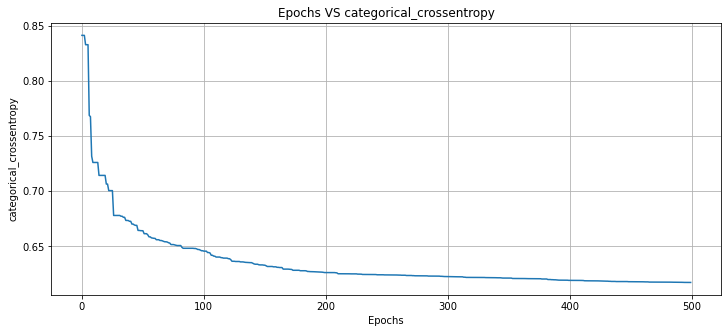

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.8988734 ]
 [0.06826572]
 [0.03286099]]
[1. 0. 0.] <-> [[0.9020849 ]
 [0.06642728]
 [0.03148792]]
[1. 0. 0.] <-> [[0.9239884 ]
 [0.05471277]
 [0.0212989 ]]
[1. 0. 0.] <-> [[0.79382175]
 [0.16090718]
 [0.04527108]]
[1. 0. 0.] <-> [[0.88406265]
 [0.07727786]
 [0.03865947]]
[1. 0. 0.] <-> [[0.70899844]
 [0.236859  ]
 [0.05414259]]
[1. 0. 0.] <-> [[0.87765694]
 [0.0816223 ]
 [0.04072087]]
[0. 1. 0.] <-> [[0.87833244]
 [0.08114691]
 [0.04052068]]
[0. 1. 0.] <-> [[0.0569758 ]
 [0.3520473 ]
 [0.59097683]]
[1. 0. 0.] <-> [[0.41236797]
 [0.30595797]
 [0.28167403]]
[1. 0. 0.] <-> [[0.89573115]
 [0.07009459]
 [0.03417424]]
[0. 1. 0.] <-> [[0.39892942]
 [0.3065534 ]
 [0.2945172 ]]
[1. 0. 0.] <-> [[0.75362384]
 [0.1994902 ]
 [0.04688594]]
[1. 0. 0.] <-> [[0.539352  ]
 [0.30053663]
 [0.16011138]]
[1. 0. 0.] <-> [[0.8405524 ]
 [0.11389708]
 [0.04555043]]
[1. 0. 0.] <-> [[0.92272586]
 [0.05532828]
 [0.02194577]]
[1. 0. 0.] <-> [[0.88617724]
 [0.07591639]
 [0.03790639]]
[1. 0. 0.] <->

In [12]:
# Testing Performance

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8271604938271605, 'mean_square_error': 2.932480629224198, 'categorical_crossentropy': 0.6822073901141131, 'precision': 0.7407407407407407, 'recall': 0.7407407407407407, 'f1': 0.7407407407407407, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 21, 'tn_hit': 9, 'fn_hit': 1}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 7, 'tn_hit': 87, 'fn_hit': 11}}, 'checkpoint': 100} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.9297544018720454, 'categorical_crossentropy': 0.6657704247368706, 'precision': 0.7592592592592593, 'recall': 0.7592592592592593, 'f1': 0.7592592592592593, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 21, 'tn_hit': 9, 'fn_hit': 1}, 1: {'tp_hit': 2, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 14}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 200} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.9553946535378617, 'categorical_crossentropy': 0.667005044442636, 'precision': 0

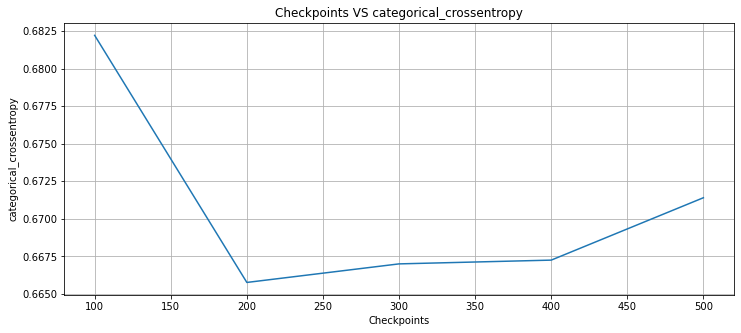

In [14]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

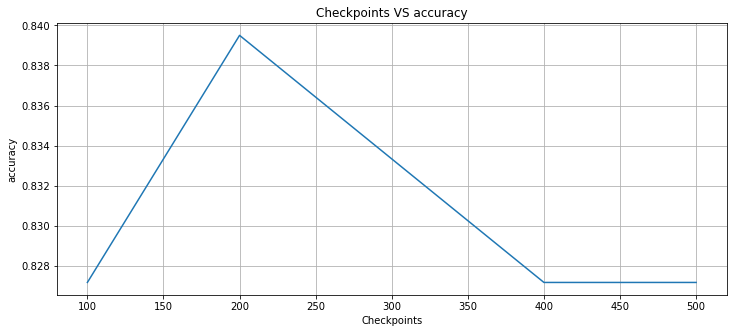

In [15]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [16]:
print(model)

Layer 1
Neuron 0: weights:
[[-1.5090237]
 [-0.5489581]
 [-2.9916766]
 [ 0.7161914]
 [ 0.653165 ]]
 bias: [3.]

Neuron 1: weights:
[[ 0.4587297]
 [-2.629689 ]
 [ 2.608182 ]
 [ 1.1822046]
 [-0.6938028]]
 bias: [-1.3289804]

Neuron 2: weights:
[[-0.78983563]
 [-2.227857  ]
 [-0.8075654 ]
 [ 2.043879  ]
 [ 1.5134498 ]]
 bias: [0.02471637]

Neuron 3: weights:
[[ 0.801688 ]
 [-1.4385756]
 [ 0.7022182]
 [-3.       ]
 [-2.9348965]]
 bias: [-1.5958925]

$
Layer 2
Neuron 0: weights:
[[-0.42946517]
 [-3.        ]
 [ 1.9390683 ]
 [-1.3656436 ]]
 bias: [2.5956192]

Neuron 1: weights:
[[-0.09350073]
 [ 1.7791306 ]
 [ 1.8534365 ]
 [-2.1162415 ]]
 bias: [0.13132578]

Neuron 2: weights:
[[-2.0069144]
 [ 1.2778865]
 [-1.0974748]
 [-0.909755 ]]
 bias: [1.8943638]

$

